In [160]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
import os 


In [161]:
def reshape_data_to_fit(data):
    num_samples = len(data)
    num_features = 1
    x_train = tf.reshape(data, (num_samples, 1, 1, 1))
    return x_train


In [162]:
# append datasets to one another, this may damage temporal link
rawSignals = []
datadir = "Data\PreviousData_v2\\"
for each in os.listdir("Data\PreviousData_v2"):
    rawSignals.append(list(scipy.io.loadmat(datadir+each)["X"][0]))

x_train = []
for signal in rawSignals:
    i = 0
    while (i + 1000) < len(signal):
        # row of zeros in place of where a 2nd+++ signal will be    
        temp = np.vstack((signal[i:i+1000], np.zeros(1000)))
        # needs to be 3d, so insert empty dimension
        temp = temp.reshape((1, 1, 2, 1000))
        # create list of training sets
        x_train.append(temp)
        i += 1000

print(x_train[0].shape)


(1, 1, 2, 1000)


In [163]:
# generate 250hz time series

# i = 0
# g = 0
# timeseries = []
# while i != len(data):
#     if i < len(data):
#         timeseries.append(g)
#         g += 1 / 250
#         i += 1

In [164]:
# comparing the distribution of the encoded representations of the input data with Gaussian distribution

def mmd_loss(u, v):
    #I am unsure of what sigma to use, i googled it is a hyperparameter with value dependant on kernal size
    #please advise
    sigmas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] #trying a couple different sigmas
    gaussian_kernel = lambda x, y, sigma: tf.exp(-tf.reduce_mean(tf.square(x - y), axis=1) / (2 * sigma ** 2))

    loss = 1.0
    for sigma in sigmas:
        #difference between spaces?
        #resid = v[:len(u) // 2] - v[len(u) // 2:] 

        #I don't really know what "h" is, so I need a little help there
        temp = tf.reduce_mean(gaussian_kernel(u, v, sigma))
        if loss > temp: #taking the lowest sigma
            loss = temp
    return loss


def t2_loss(y_true, y_pred): #i think this is not working
    return tf.nn.l2_loss(y_true - y_pred)
    

In [165]:
# built in the way the paper describes

def build_encoder(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Flatten()(x) #this layer was not in the paper
    x = layers.Dense(64, activation='relu')(x) #unsure of how else to get to the next layer without it

    encoder = tf.keras.Model(inputs, x, name='encoder')

    return encoder

def build_decoder(latent_dim=64):
    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    
    x = layers.Reshape((1, 1, latent_dim))(latent_inputs)

    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(1, (3, 3), activation='relu', padding='same')(x)

    decoder = tf.keras.Model(latent_inputs, x, name='decoder')
    
    return decoder

def build_autoencoder(encoder, decoder):
    inputs = encoder.inputs
    x = encoder(inputs)
    outputs = decoder(x)
    
    autoencoder = tf.keras.Model(inputs, outputs, name='autoencoder')
    
    return autoencoder

encoder = build_encoder((1, 2, 1000))
decoder = build_decoder()
autoencoder = build_autoencoder(encoder, decoder)
autoencoder.summary()

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(x_train[0], x_train[0], epochs=10, batch_size=32)


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 1, 2, 1000)]      0         
                                                                 
 encoder (Functional)        (None, 64)                310688    
                                                                 
 decoder (Functional)        (None, 4, 4, 1)           55681     
                                                                 
Total params: 366,369
Trainable params: 366,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


ValueError: in user code:

    File "C:\Users\ianja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\ianja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ianja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\ianja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\ianja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "C:\Users\ianja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\ianja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\ianja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\ianja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 1500, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 4 and 2 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](autoencoder/decoder/conv2d_transpose_41/Relu, IteratorGetNext:1)' with input shapes: [?,4,4,1], [?,1,2,1000].


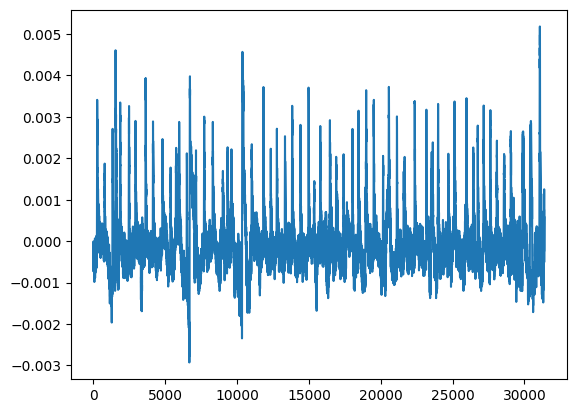

981/981 [==============================] - 1s 690us/step


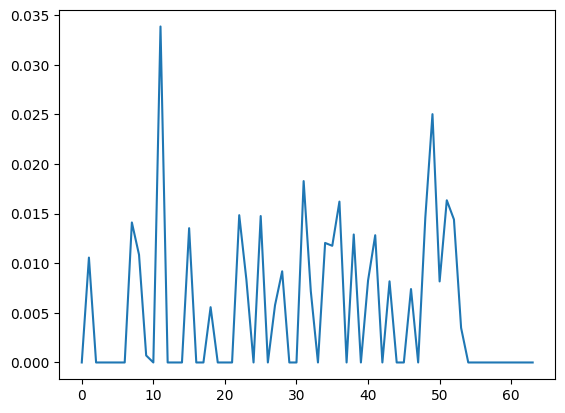

In [ ]:
mat = scipy.io.loadmat('162109.mat')
data1 = reshape_data_to_fit(mat["X"][0])
unwrapped_arr = np.reshape(data1, -1)

plt.plot(list(unwrapped_arr))
plt.show()

# Use the encoder to encode the data
encoded_data = encoder.predict(data1)
# decoded_data = decoder.predict(encoded_data) ?
plt.plot(list(encoded_data)[0])
plt.show()